In [1]:
!pip install transformers > /dev/null

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

from transformers import RobertaTokenizer, RobertaModel, PreTrainedTokenizer

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from copy import deepcopy
import matplotlib.pyplot as plt

from typing import NoReturn, Tuple, List
from tqdm import tqdm, trange
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE = 64
MAX_LEN = 128
DEVICE = "cuda"

In [5]:
data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/train_tweets.csv').drop(['id'], axis=1)
train_data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/train_data.csv')
val_data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/val_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/test_data.csv')

In [ ]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


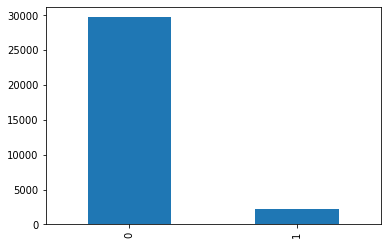

In [ ]:
data['label'].value_counts().plot.bar()
plt.show()

# Balancing out the data
- объединение случайных твитов класса 1
- добавление копий твитов
- downsampling доминирующего класса 0

In [ ]:
data.shape

(31962, 2)

In [ ]:
def concat_samples(data: pd.DataFrame, class_: int, n_new_samples: int, 
                   min_n_concat: int = 2, max_n_concat: itn = 3) -> pd.DataFrame:
    for _ in range(n_new_samples):
        samples = data.loc[data['label'] == class_]\
        .sample(np.random.randint(min_n_concat, max_n_concat + 1))['tweet']\
        .to_list()

        new_entry = {'label': 1, 
                    'tweet': ' '.join(samples)}
        data = data.append(new_entry, ignore_index=True)
    return data

def copy_samples(data: pd.DataFrame, class_: int, 
                 n_new_samples: int, **kwargs) -> pd.DataFrame:
    samples = data.loc[data['label'] == class_]\
        .sample(n_new_samples)
    data = data.append(samples)
    return data

def bootstrap(data: pd.DataFrame, class_: int, n_new_samples: int, 
              min_n_concat: int = 2, max_n_concat: int = 3) -> pd.DataFrame:
    methods = [concat_samples, copy_samples]
    for _ in range(n_new_samples):
        method = methods[np.random.randint(0, 2)]
        data = method(data, class_, 1, min_n_concat=2, max_n_concat=3)
    return data

In [ ]:
data = bootstrap(data, 1, 5000)

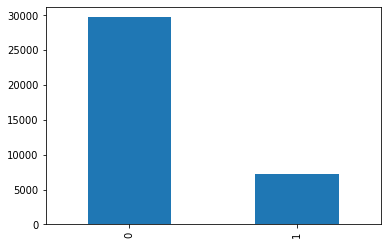

In [ ]:
data['label'].value_counts().plot.bar()
plt.show()

In [ ]:
data['label'].value_counts()

0    29720
1     7242
Name: label, dtype: int64

In [ ]:
negative = data.loc[data['label'] == 0].sample(7500)
positive = data.loc[data['label'] == 1]
new_data = pd.concat([negative, positive])
# shuffling
new_data = new_data.sample(frac=1)

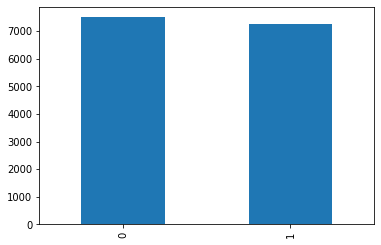

In [ ]:
new_data['label'].value_counts().plot.bar()
plt.show()

# Train / Val / Test split

In [7]:
val_data = new_data.sample(frac=0.2)
train_data = new_data.drop(val_data.index)

test_data = val_data.sample(frac=0.5)
val_data = val_data.drop(test_data.index)

In [8]:
train_data.to_csv('/content/drive/MyDrive/NLP/tweets/train_data.csv')
val_data.to_csv('/content/drive/MyDrive/NLP/tweets/val_data.csv')
test_data.to_csv('/content/drive/MyDrive/NLP/tweets/test_data.csv')

In [9]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

In [10]:
def prepare_dataloader(dataframe: pd.DataFrame, 
                       tokenizer: PreTrainedTokenizer) -> DataLoader:
    encodings = tokenizer(
            dataframe['tweet'].to_list(), 
            return_token_type_ids=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors="pt").to(DEVICE)
    labels = torch.tensor(dataframe['label'].to_numpy(), dtype=torch.long).to(DEVICE)
    dataset = TensorDataset(encodings["input_ids"], 
                           encodings["attention_mask"], labels)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
train_dataloader = prepare_dataloader(train_data, tokenizer)
val_dataloader = prepare_dataloader(val_data, tokenizer)
test_dataloader = prepare_dataloader(test_data, tokenizer)

# Модель

In [12]:
class RobertaClassifier(nn.Module):
    def __init__(self, hidden_size: int, n_classes: int, dropout: float):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.fc1 = nn.Linear(768, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, n_classes)
    
    def forward(self, input_ids: torch.Tensor, 
                attention_mask: torch.Tensor) -> torch.Tensor:
        z = self.roberta(input_ids, attention_mask)
        z = self.fc1(z.pooler_output)
        z = self.relu(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z
    
    def get_labels(self, input_ids: torch.Tensor, 
                   attention_mask: torch.Tensor) -> torch.Tensor:
        z = self.forward(input_ids, attention_mask)
        return torch.argmax(z, dim=1)

In [13]:
def accuracy(output: torch.Tensor, labels: torch.Tensor) -> float:
    return torch.sum(torch.argmax(output, dim=1) == labels).item() / len(labels)

In [14]:
def train(model: nn.Module, train_dataloader: DataLoader, 
          val_dataloader: DataLoader, lr: float = 3e-4, 
          epochs: int = 5, freeze_roberta: bool = True, 
          min_val_loss: float = np.inf, 
          save_path: str = '/content/drive/MyDrive/NLP/tweets/roberta.pt') -> NoReturn:
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    min_val_loss = min_val_loss
    # freezing roberta
    if freeze_roberta:
        for param in model.roberta.parameters():
            param.requires_grad = False
    # t = trange(epochs, desc='Starting...', position=2, leave=True)
    for epoch in range(epochs):
        total_train_loss = 0
        total_train_acc = 0

        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            input_ids, attention_mask, labels = batch
            model.zero_grad()

            output = model.forward(input_ids, attention_mask)
            loss = loss_func(output, labels)
            total_train_loss += loss.item()
            total_train_acc += accuracy(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_train_loss = total_train_loss / (i + 1)
        avg_train_acc = total_train_acc / (i + 1)

        total_val_loss = 0
        total_val_acc = 0

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                input_ids, attention_mask, labels = batch
                output = model.forward(input_ids, attention_mask)
                loss = loss_func(output, labels)
                total_val_loss += loss.item()
                total_val_acc += accuracy(output, labels)
            
        avg_val_loss = total_val_loss / (i + 1)
        avg_val_acc = total_val_acc / (i + 1)
        
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        # t.set_description(f"Epoch {epoch + 1}: train loss {avg_train_loss} val loss {avg_val_loss} val acc {avg_val_acc}")
        print(f"Epoch {epoch + 1}: train loss {avg_train_loss:.3f} val loss {avg_val_loss:.3f} val acc {avg_val_acc:.3f}")
            

In [18]:
def test(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
            input_ids, attention_mask, labels = batch
            output = model.forward(input_ids, attention_mask)
            total_acc += accuracy(output, labels)

    avg_acc = total_acc / (i + 1)
    return avg_acc

In [15]:
model = RobertaClassifier(hidden_size=768, n_classes=2, dropout=0.3).to(DEVICE)

In [ ]:
acc_before_training = test(model, test_dataloader)

In [ ]:
train(model, train_dataloader, val_dataloader, lr=3e-5, epochs=65)

In [ ]:
train(model, train_dataloader, val_dataloader, lr=3e-5, 
      epochs=5, freeze_roberta=False, min_val_loss=0.25)

In [21]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/tweets/roberta.pt'))

<All keys matched successfully>

In [ ]:
acc_after_training = test(model, test_dataloader)

# Precision-Recall Curve

In [23]:
def get_pr_values(model: nn.Module, dataloader: 
                  DataLoader, class_: int) -> Tuple[List, List]:
    softmax = nn.Softmax(dim=1)
    precisions, recalls = [], []
    thresholds = np.linspace(0., 1., 10)

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
            input_ids, attention_mask, labels = batch
            if i == 0:
                output = softmax(model.forward(input_ids, attention_mask))
                all_labels = deepcopy(labels)
            else:
                out = softmax(model.forward(input_ids, attention_mask))
                output = torch.cat((output, out), dim=0)
                all_labels = torch.cat((all_labels, labels), dim=0)
    
    for th in thresholds:
        pred = [(1 if x[class_] >= th else 0) for x in output]
        pr = precision_score(all_labels.cpu(), pred, average='binary', pos_label=class_, zero_division=1)
        rec = recall_score(all_labels.cpu(), pred, average='binary', pos_label=class_)
        precisions.append(pr)
        recalls.append(rec)
    
    return precisions, recalls
            

In [ ]:
precisions_train, recalls_train = get_pr_values(model, train_dataloader, 1)
precisions_val, recalls_val = get_pr_values(model, val_dataloader, 1)
precisions_test, recalls_test = get_pr_values(model, test_dataloader, 1)

In [27]:
def plot_pr_curve(recalls_test: List, precisions_test: List, 
                  recalls_val: List = None, 
                  precisions_val: List = None,
                  recalls_train: List = None, 
                  precisions_train: List = None) -> NoReturn:

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(recalls_test, precisions_test, c='r', label="test")
    if recalls_val is not None and precisions_val is not None:
        ax.plot(recalls_val, precisions_val, c='b', label="val")
    if recalls_train is not None and precisions_train is not None:
        ax.plot(recalls_train, precisions_train, c='black', label="train")
    ax.plot([0, 1], [1, 0], linestyle="--", c='orange')

    ax.margins(0)
    ax.set_xticks(np.arange(0., 1., 0.1))
    ax.set_yticks(np.arange(0., 1., 0.1))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("PR-Curve")
    plt.legend()
    plt.show()

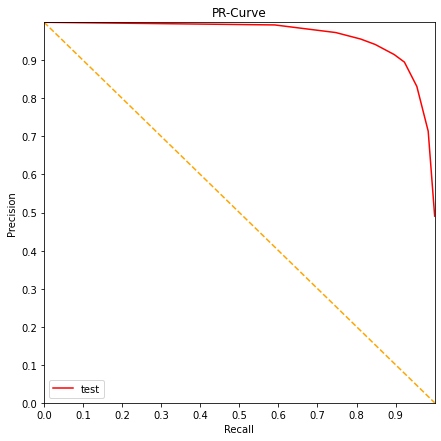

In [30]:
plot_pr_curve(recalls_test, precisions_test)

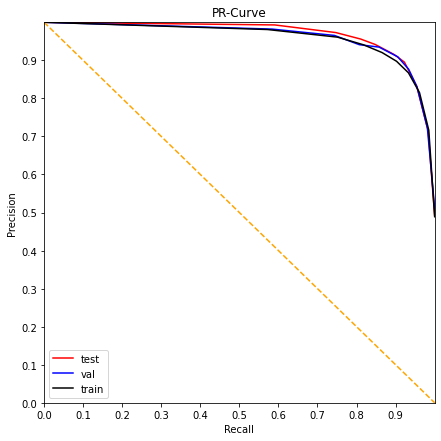

In [29]:
plot_pr_curve(recalls_test, precisions_test, 
              recalls_val, precisions_val, recalls_train, precisions_train)

# Финальные титры



In [36]:
print("Точность на тестовых данных:")
print(f"до обучения: {acc_before_training:.2f}")
print(f"последняя сохраненная модель после обучения: {acc_after_training:.2f}")

Точность на тестовых данных:
до обучения: 0.53
последняя сохраненная модель после обучения: 0.91


Обученная модель показывает результат лучше случайной (необученной) классификации.


С уменьшением порога классификации (от 1 до 0) precision уменьшается, а recall растет, то есть больше твитов начинает попадать в класс 1, но при этом среди них появляется и много твитов класса 0. Минимальный precision показывает отношение класса 1 ко всем элементам (в нашем случае около 0.5, так как выборка была сбалансирована)

Выбор порога зависит от того, что важнее: точно классифицировать как можно больше расистских/сексистских твитов, захватив с ними и нейтральные, или брать только те, в которых модель максимально уверена, упуская некоторые негативные твиты из-за меньшей уверенности модели.